# Family Size and Income in Mongolia

Our goal is simple, determine the average household income by the number of children (those under 18) in the household.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

plt.style.use('mds.mplstyle')

### Basicvars data

In [2]:
basicvars = pd.read_stata('data/basicvars.dta')

In [3]:
basicvars.head()

,identif,cluster,newaimag,location,urban,region,quarter,strata,hhweight,hhsize
0,1,1,Dornod,Aimagcenter,Urban,East,1,2,105.033333,4
1,2,1,Dornod,Aimagcenter,Urban,East,1,2,105.033333,4
2,3,1,Dornod,Aimagcenter,Urban,East,1,2,105.033333,8
3,4,1,Dornod,Aimagcenter,Urban,East,1,2,105.033333,3
4,5,1,Dornod,Aimagcenter,Urban,East,1,2,105.033333,2


As Ulaanbaatar has a higher average salary than the countryside, we want to check for that. From the basicvars dataframe we want:
- identif: Household ID
- newaimag: The aimag (province)
- urban: Urban or rural. Rural is a soum center or countryside. Urban is an aimag center or Ulaanbaatar.

In [4]:
basicvars = basicvars[['identif','newaimag','urban']]

In [5]:
basicvars.head()

,identif,newaimag,urban
0,1,Dornod,Urban
1,2,Dornod,Urban
2,3,Dornod,Urban
3,4,Dornod,Urban
4,5,Dornod,Urban


### Individual Data

In [6]:
individual = pd.read_stata('data/02_indiv.dta')

In [7]:
individual.head()

,identif,ind_id,q0102,q0103,q0104y,q0105y,q0105m,q0106,q0107,q0108a,...,q0207,q0208,q0209,q0210a,q0210b,q0210c,q0211,q0212a,q0212b,q0212c
0,1,1,HEAD,MALE,1971,47,NaN,LIVING TOGETHER,2.0,0,...,1061.000000,LLC,YES,700000.0,8400000.0,0.0,NO,NaN,NaN,NaN
1,1,2,WIFE / HUSBAND,FEMALE,1971,47,NaN,LIVING TOGETHER,1.0,10,...,1061.000000,LLC,YES,300000.0,3600000.0,420000.0,NO,NaN,NaN,NaN
2,1,3,SON / DAUGHTER,FEMALE,1991,27,NaN,MARRIED,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,SON / DAUGHTER,MALE,2009,9,NaN,NaN,NaN,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,1,HEAD,FEMALE,1978,40,NaN,NEVER MARRIED,NaN,0,...,5610.100098,LLC,YES,0.0,2500000.0,0.0,NO,NaN,NaN,NaN


From the individual dataframe we need:
- identif: Household ID
- q0105y: age of family member
- q0210b: salary in past 12 months
- q0212b: salary in past 12 months from 2nd job

In [8]:
individual = individual[['identif','q0105y','q0210b','q0212b']]

## Feature Creation

We need to calculate the household income and the number of children in the household.

In [9]:
individual.isna().sum()

identif        0
q0105y         0
q0210b     31470
q0212b     40524
dtype: int64

In [10]:
individual = individual.fillna(0)

In [11]:
individual['household_income'] = individual['q0210b'] + individual['q0212b']

In [12]:
individual['children'] = individual['q0105y'] < 18

In [13]:
individual.head()

,identif,q0105y,q0210b,q0212b,household_income,children
0,1,47,8400000.0,0.0,8400000.0,False
1,1,47,3600000.0,0.0,3600000.0,False
2,1,27,0.0,0.0,0.0,False
3,1,9,0.0,0.0,0.0,True
4,2,40,2500000.0,0.0,2500000.0,False


In [14]:
household = individual.groupby(by='identif').sum()

In [15]:
individual.groupby(by='identif').mean()['q0105y']

identif
1        32.500000
2        35.750000
3        22.000000
4        48.666667
5        71.000000
           ...    
11193    36.250000
11194    34.500000
11195    51.333333
11196    58.000000
11197    19.400000
Name: q0105y, Length: 11197, dtype: float64

In [16]:
household = household.drop(columns=['q0105y','q0210b','q0212b'])

In [17]:
individual.groupby(by='identif').mean()['q0105y']

identif
1        32.500000
2        35.750000
3        22.000000
4        48.666667
5        71.000000
           ...    
11193    36.250000
11194    34.500000
11195    51.333333
11196    58.000000
11197    19.400000
Name: q0105y, Length: 11197, dtype: float64

In [18]:
individual['adult'] = individual[individual['q0105y'] >= 18]['q0105y']

In [19]:
household = household.merge(individual.groupby(by='identif').mean().reset_index()[['identif','adult']], on='identif')

In [20]:
household = household.rename(columns={'q0105y':'adult_avg_age'})

In [21]:
household.head()

,identif,household_income,children,adult
0,1,12000000.0,1,40.333333
1,2,2500000.0,2,59.000000
2,3,3600000.0,5,40.666667
3,4,1500000.0,0,48.666667
4,5,0.0,0,71.000000


In [22]:
basicvars.head()

,identif,newaimag,urban
0,1,Dornod,Urban
1,2,Dornod,Urban
2,3,Dornod,Urban
3,4,Dornod,Urban
4,5,Dornod,Urban


In [23]:
household = household.merge(basicvars, on='identif', how='left')

In [24]:
household.head()

,identif,household_income,children,adult,newaimag,urban
0,1,12000000.0,1,40.333333,Dornod,Urban
1,2,2500000.0,2,59.000000,Dornod,Urban
2,3,3600000.0,5,40.666667,Dornod,Urban
3,4,1500000.0,0,48.666667,Dornod,Urban
4,5,0.0,0,71.000000,Dornod,Urban


And that's it! Our data is ready. Let's make some visualizations.

## Visualizations

In [25]:
household.dtypes

identif                int64
household_income     float64
children               int64
adult                float64
newaimag            category
urban               category
dtype: object

In [26]:
household['children'].max()

9

In [27]:
income_children = []
for number in np.arange(0,10):
    income_children.append((number, 
                            household[household['children'] == number]['household_income'].mean() / 1_000_000))

In [28]:
income_children

[(0, 4.067218569292123),
 (1, 7.459911961432507),
 (2, 8.419987020408163),
 (3, 7.9385875979522185),
 (4, 6.659878674576271),
 (5, 5.074995327102804),
 (6, 6.538347826086956),
 (7, 8.485714285714286),
 (8, 4.9),
 (9, 3.5)]

These numbers match with our hypothesis, that higher numbers of children correlate to lower incomes. The exception is at 8 children, where there is a spike at 14.95 million. This is probably because of a low number of samples in with that number of children.

In [29]:
records = []
for number in np.arange(0,10):
    records.append((number, household[household['children'] == number].shape[0]))

In [30]:
records

[(0, 4012),
 (1, 2541),
 (2, 2450),
 (3, 1465),
 (4, 590),
 (5, 107),
 (6, 23),
 (7, 7),
 (8, 1),
 (9, 1)]

With this in mind we can safely remove anything above 5 children.

In [31]:
household = household[household['children'] <= 5].reset_index(drop=True)

For extra info we also want to see the average age of households by number of children.

In [32]:
avg_age = []
for number in np.arange(0,6):
    avg_age.append((number, household[household['children'] == number]['adult'].mean()))

In [33]:
avg_age

[(0, 50.911019322983435),
 (1, 39.04119563179602),
 (2, 36.06981924198251),
 (3, 36.175702576112414),
 (4, 36.92188660209847),
 (5, 36.82745883400089)]

We also want to see if there are significant differences between urban/rural. If the distributions are inconsistent we should look into it more.

In [34]:
household.head()

,identif,household_income,children,adult,newaimag,urban
0,1,12000000.0,1,40.333333,Dornod,Urban
1,2,2500000.0,2,59.000000,Dornod,Urban
2,3,3600000.0,5,40.666667,Dornod,Urban
3,4,1500000.0,0,48.666667,Dornod,Urban
4,5,0.0,0,71.000000,Dornod,Urban


In [35]:
income_children_urban = []
for number in np.arange(0,6):
    income_children_urban.append((number, 
                                  household[(household['children'] == number) & (household['urban'] == 'Urban')]['household_income'].mean() / 1_000_000))

In [36]:
income_children_urban

[(0, 5.89789425645933),
 (1, 9.952720346361186),
 (2, 11.00448874471086),
 (3, 11.26899737409201),
 (4, 9.560756857142856),
 (5, 8.18462962962963)]

In [37]:
income_children_rural = []
for number in np.arange(0,6):
    income_children_rural.append((number, 
                                  household[(household['children'] == number) & (household['urban'] == 'Rural')]['household_income'].mean() / 1_000_000))

In [38]:
income_children_rural

[(0, 2.076525444328824),
 (1, 3.9600750236518447),
 (2, 4.868801511627907),
 (3, 3.633550860719875),
 (4, 3.3370545745454545),
 (5, 1.906688679245283)]

In [39]:
urban_rural = []
for number in np.arange(0,6):
    avg_age.append((number, household[household['children'] == number]['adult'].mean()))

This function remakes our currency values to have the K and M suffix (K for thousands and M for millions). [Adapted from Jie Jenn](https://www.youtube.com/watch?v=l-j9Mmi7VPk).

In [40]:
def format_number(data_value, indx):
    if data_value >= 1_000:
        formatter = '{:1.1f}M'.format(data_value*0.000001)
    else:
        formatter = '{:1.0f}K'.format(data_value)
    return formatter

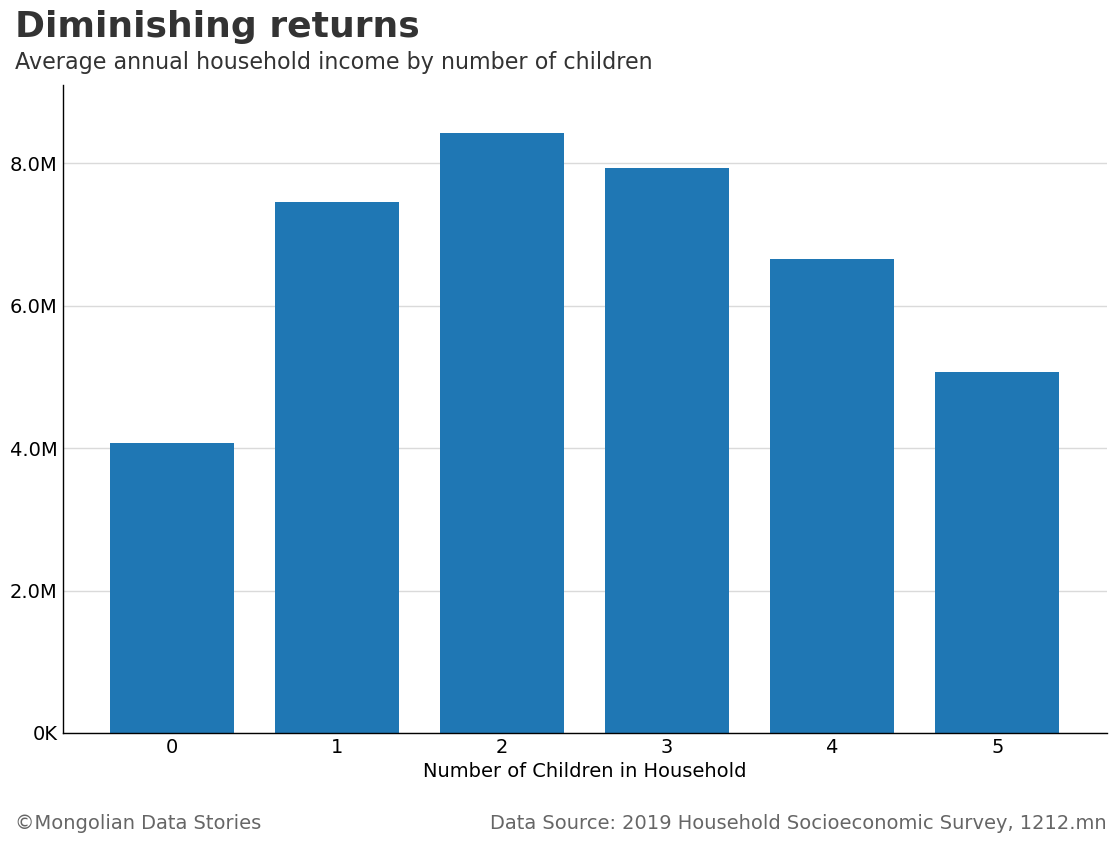

In [41]:
fig, ax = plt.subplots()

# Prep Data
income_children = []
for number in np.arange(0,6):
    income_children.append(household[household['children'] == number]['household_income'].mean())

ax.bar(np.arange(0,6), income_children, width=.75, color='tab:blue')

ax.set_ylim(0, 9_100_000)

ax.set_xlabel('Number of Children in Household')

# Add grid
ax.grid(axis='y', alpha=.7)

# Relabel y-axis to give pretty numbers
ax.yaxis.set_major_formatter(format_number)

# Set title and subtitle
ax.text(x=0.04, y=.94, s="Diminishing returns", transform=fig.transFigure, ha='left', fontsize=26, weight='bold', alpha=.8)
ax.text(x=0.04, y=.90, s="Average annual household income by number of children", transform=fig.transFigure, ha='left', fontsize=16, alpha=.8)

# Set bottom banner
ax.text(x = 0.04, y = -0.05, s = '©Mongolian Data Stories', transform=fig.transFigure, ha='left', fontsize = 14, alpha=.6)
ax.text(x = .95, y = -0.05, s = 'Data Source: 2019 Household Socioeconomic Survey, 1212.mn', transform=fig.transFigure, ha='right', fontsize = 14, alpha=.6)
plt.savefig('images/wages_children.png', dpi = 300, bbox_inches="tight")

In [42]:
income_children = []
for number in np.arange(0,6):
    income_children.append((number, 
                            household[household['children'] == number]['household_income'].mean() / 1_000_000))

In [43]:
(income_children[2][1] - income_children[5][1]) / income_children[2][1]

0.3972680344040731

## Fertility

In [44]:
fertility = pd.read_csv('data/API_SP.DYN.TFRT.IN_DS2_en_csv_v2_3471714.csv')

In [45]:
fertility = fertility.drop(columns=['Country Code','Indicator Name','Indicator Code'])

In [46]:
fertility[fertility['Country Name'] == 'United Kingdom']

,Country Name,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
81,United Kingdom,2.69,2.78,2.86,2.88,2.93,2.86,2.78,2.68,2.6,...,1.91,1.92,1.83,1.81,1.8,1.79,1.74,1.68,1.65,NaN


In [47]:
countries = ['Mongolia','United States','India','China','Germany']

fertility = fertility[fertility['Country Name'].isin(countries)]
fertility.head()

,Country Name,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
40,China,5.756,5.905,6.062,6.206,6.320,6.385,6.384,6.316,6.184,...,1.6320,1.6390,1.6470,1.6560,1.6650,1.6750,1.6830,1.6900,1.696,NaN
55,Germany,2.370,2.450,2.440,2.510,2.540,2.500,2.530,2.480,2.380,...,1.3900,1.4100,1.4200,1.4700,1.5000,1.6000,1.5700,1.5700,1.540,NaN
109,India,5.906,5.902,5.894,5.880,5.859,5.830,5.794,5.751,5.702,...,2.5060,2.4390,2.3810,2.3330,2.2950,2.2660,2.2430,2.2220,2.202,NaN
163,Mongolia,6.953,7.168,7.347,7.477,7.558,7.593,7.599,7.591,7.584,...,2.7220,2.7940,2.8520,2.8940,2.9180,2.9230,2.9140,2.8950,2.867,NaN
251,United States,3.654,3.620,3.461,3.319,3.190,2.913,2.721,2.558,2.464,...,1.8945,1.8805,1.8575,1.8625,1.8435,1.8205,1.7655,1.7295,1.705,NaN


In [48]:
fertility = fertility.melt(id_vars='Country Name', var_name='year', value_name='fertility').rename(columns={'Country Name':'country'}).dropna()

In [49]:
fertility.tail()

,country,year,fertility
295,China,2019,1.696
296,Germany,2019,1.540
297,India,2019,2.202
298,Mongolia,2019,2.867
299,United States,2019,1.705


In [50]:
fertility['year'] = pd.to_datetime(fertility['year'])

In [51]:
from matplotlib.ticker import AutoMinorLocator

/var/folders/h6/t5s_1mjx40z0hhvtvsf11xf00000gn/T/ipykernel_88328/729470828.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(0,9,1),            # Set labels again


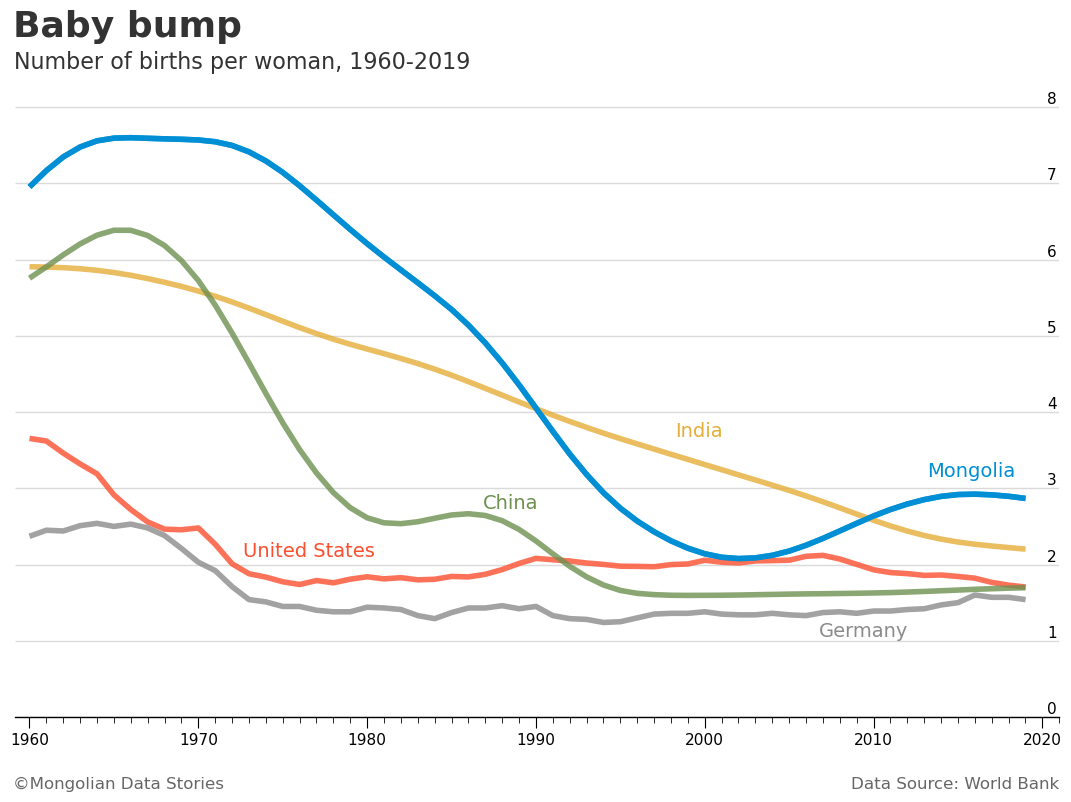

In [53]:
fig, ax = plt.subplots()

# Plot data
for country in countries:
    ax.plot(fertility[fertility['country'] == country]['year'], 
            fertility[fertility['country'] == country]['fertility'], alpha=.8)
    
ax.plot(fertility[fertility['country'] == 'Mongolia']['year'], 
        fertility[fertility['country'] == 'Mongolia']['fertility'], c='#008fd5')

ax.set_xlim(datetime.date(1959, 3, 1), datetime.date(2021, 1, 1))
ax.set_ylim(0,8.5)

# Reformat x-axis tick labels
ax.xaxis.set_tick_params(length=8, labelsize=11)        # Set tick label size
ax.xaxis.set_tick_params(which='minor', length=4)
minor_locator = AutoMinorLocator(10)
ax.xaxis.set_minor_locator(minor_locator)

# Add grid
ax.grid(axis='y', alpha=.7)

# Remove splines. Can be done one at a time or can slice with a list.
ax.spines[['top','right','left']].set_visible(False)

# Reformat y-axis tick labels
ax.set_yticklabels(np.arange(0,9,1),            # Set labels again
                   ha = 'right',                 # Set horizontal alignment to right
                   verticalalignment='bottom')   # Set vertical alignment to make labels on top of gridline      

ax.yaxis.set_tick_params(pad=-2,             # Pad tick labels so they don't go over y-axis
                         labeltop=True,      # Put x-axis labels on top
                         labelbottom=False,  # Set no x-axis labels on bottom
                         bottom=False,       # Set no ticks on bottom
                         labelsize=11)       # Set tick label size

# Add annotations
colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c']
ax.text(x = .84, y=.37, s='Mongolia', transform=fig.transFigure, fontsize = 14, color=colors[0])
ax.text(x = .27, y=.27, s='United States', transform=fig.transFigure, fontsize = 14, color=colors[1])
ax.text(x = .63, y=.42, s='India', transform=fig.transFigure, fontsize = 14, color=colors[2])
ax.text(x = .47, y=.33, s='China', transform=fig.transFigure, fontsize = 14, color=colors[3])
ax.text(x = .75, y=.17, s='Germany', transform=fig.transFigure, fontsize = 14, color=colors[4])

# Set title and subtitle
ax.text(x=0.078, y=.92, s="Baby bump", transform=fig.transFigure, ha='left', fontsize=26, weight='bold', alpha=.8)
ax.text(x=0.079, y=.88, s="Number of births per woman, 1960-2019", transform=fig.transFigure, ha='left', fontsize=16, alpha=.8)

# Set bottom banner
ax.text(x = 0.078, y = -0.02, s = '©Mongolian Data Stories', transform=fig.transFigure, ha='left', fontsize = 12, alpha=.6)
ax.text(x = .95, y = -0.02, s = 'Data Source: World Bank', transform=fig.transFigure, ha='right', fontsize = 12, alpha=.6)
plt.savefig('images/baby_bump.png', dpi = 300, bbox_inches="tight")